In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.metrics import roc_curve, auc, roc_auc_score

Using TensorFlow backend.


In [2]:
# -----------------------------LOAD IN OUR DATA---------------------------------- #
VALID = 'CheXpert-v1.0-small/valid.csv'

# generate validation set
valid = pd.read_csv(VALID, dtype=str)

##clean up the age to int then create buckets
valid['Age'] = valid['Age'].astype(str).astype(int)
age_buckets = [0, 2, 5, 13, 18, 33, 48, 64, 78, 98]
valid['age_bucket'] = pd.cut(valid['Age'], age_buckets)

##parse the path into the respective categories
new = valid["Path"].str.split("/", n = 5, expand = True)

valid['Folder'] = new[0]
valid['Data'] = new[1]
valid['Patient'] = new[2]
valid['Study'] = new[3]
valid['viewNumber']= new[4].str.split("_", n = 2, expand = True)[0]
valid['ImageType']= new[4].str.split("_", n = 2, expand = True)[1]

#mapping to different labels
label = {'0.0': '0', '1.0' : '1', '-1.0' : '1'}

#same for validation set even though there should be no issue here with missing data
valid['label'] = valid['Pleural Effusion'].map(label)
num_valid = len(valid)

print(valid['label'].value_counts())


0    167
1     67
Name: label, dtype: int64


In [18]:
#---------------------------------CREATE TEST DATA GENERATOR---------------------------------#
def test_flow(valid, target_size, batch_size = 1, color_mode="rgb",  x = 'Path', y= 'label'):

    #declare the datagen options
    valid_datagen = ImageDataGenerator(rescale=1./255)

    valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid,
                                                        directory=None,
                                                        x_col=x,
                                                        y_col=y,
                                                        class_mode="binary",
                                                        color_mode=color_mode,
                                                        seed = 42,
                                                        shuffle = False,
                                                        target_size=target_size,
                                                        batch_size=batch_size)

    return valid_generator

## DenseNet Evaluation

In [19]:
valid_generator = test_flow(valid, (224,224), color_mode="rgb")

Found 234 validated image filenames belonging to 2 classes.


In [23]:
from keras.applications.densenet import DenseNet121 as BASE
WEIGHTS = 'DenseNet121_16_6_weights_lr_reduce_from32.hdf5'

conv_base = BASE(include_top=True,
                input_shape=valid_generator.image_shape,
                pooling=max)

conv_base.layers.pop()
# print(conv_base.summary())

# conv_base.trainable = True
# for layer in conv_base.layers:
#     layer.trainable = True

model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(1, activation='sigmoid'))

if WEIGHTS:
    model.load_weights(WEIGHTS)

model.compile(loss='binary_crossentropy', optimizer= optimizers.Adam(), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1000)              7037504   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 7,038,505
Trainable params: 6,954,857
Non-trainable params: 83,648
_________________________________________________________________
None


In [24]:
scoreSeg = model.evaluate_generator(valid_generator, steps=len(valid), workers=0)
print('--------------------------')
print('')
print("Accuracy (Evaluation Generator)= ",scoreSeg[1])
print('')

--------------------------

Accuracy (Evaluation Generator)=  0.8803418803418803



In [25]:
valid_generator.reset()
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

y_pred = model.predict_generator(valid_generator, steps=STEP_SIZE_VALID, verbose=1, workers=0)

234/234 [==============================] - 84s 357ms/step


In [26]:
valid['densenet'] = y_pred

valid['y_pred_densenet'] = round(valid['densenet'])

pd.crosstab(valid['label'], valid['y_pred_densenet'])

y_pred_densenet,0.0,1.0
label,,
0,161,6
1,22,45


One issue we see immediately is the ammount of false negatives in our group. I would think that is our most concerning group as it shows that we miss almost 32% of our positive cases! This makes some sense as we have an imbalanced training data set.

In [27]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_generator.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print('--------------------------')
print('')
print('Model AUC: %s' % str(round(auc_keras, 4)))
print('')
print('--------------------------')

--------------------------

Model AUC: 0.9198

--------------------------


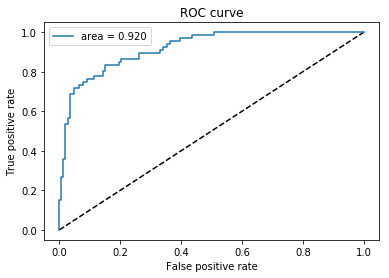

In [28]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Our model AUC is not significantly worse that the baseline, although it does not perform better, and considering our errors are primarily related to false negatives it is difficult to gauge the reliability of this model.

## MobileNetV2 Evaluations

In [32]:
valid_generator = test_flow(valid, (320,320), color_mode="rgb")

Found 234 validated image filenames belonging to 2 classes.


In [30]:
# load model
model = load_model('/home/newall/MSDS/MSDSCapstone/MobileNetV2_16_6_model_320x320_v2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_320 (Model) (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [33]:
scoreSeg = model.evaluate_generator(valid_generator, steps=len(valid), workers=0)
print('--------------------------')
print('')
print("Accuracy (Evaluation Generator)= ",scoreSeg[1])
print('')

--------------------------

Accuracy (Evaluation Generator)=  0.8547008547008547



In [34]:
valid_generator.reset()
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

y_pred = model.predict_generator(valid_generator, steps=STEP_SIZE_VALID, verbose=1, workers=0)

234/234 [==============================] - 68s 291ms/step


In [35]:
valid['mobilenet'] = y_pred

valid['y_pred_mobilenet'] = round(valid['mobilenet'])

pd.crosstab(valid['label'], valid['y_pred_mobilenet'])

y_pred_mobilenet,0.0,1.0
label,,
0,151,16
1,18,49


In [36]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_generator.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print('--------------------------')
print('')
print('Model AUC: %s' % str(round(auc_keras, 4)))
print('')
print('--------------------------')

--------------------------

Model AUC: 0.9002

--------------------------


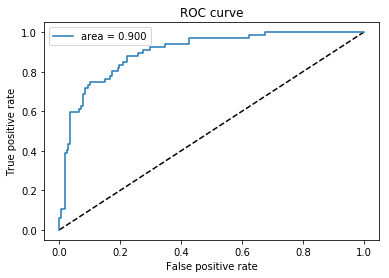

In [37]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Patient Level Evaluations

In [65]:
valid['patient_id'] = [item[2] for item in valid['Path'].str.split("/")]
valid['study_id'] = [item[3] for item in valid['Path'].str.split("/")]

In [66]:
groupLabel = ['patient_id','study_id','Sex','Age','label']
test = valid[['patient_id','study_id','Sex','Age','label','mobilenet','densenet']].groupby(groupLabel).max().reset_index()

In [67]:
test['mobilenet_pred'] = round(test['mobilenet'])
test['densenet_pred'] = round(test['densenet'])

pd.crosstab(test['label'], test['mobilenet_pred'])

mobilenet_pred,0.0,1.0
label,,
0,120,16
1,15,49


In [68]:
pd.crosstab(test['label'], test['densenet_pred'])

densenet_pred,0.0,1.0
label,,
0,130,6
1,20,44


In [44]:
labels = list(map(int, list(test['label'])))

In [45]:
fpr_mobilenet, tpr_mobilenet, thresholds_mobilenet = roc_curve(labels, test['mobilenet'])
auc_mobilenet = auc(fpr_mobilenet, tpr_mobilenet)
print('--------------------------')
print('')
print('MobileNet AUC: %s' % str(round(auc_mobilenet, 4)))
print('')
print('--------------------------')

--------------------------

MobileNet AUC: 0.8953

--------------------------


In [46]:
fpr_densenet, tpr_densenet, thresholds_densenet = roc_curve(labels, test['densenet'])
auc_densenet = auc(fpr_densenet, tpr_densenet)
print('--------------------------')
print('')
print('DenseNet121 AUC: %s' % str(round(auc_densenet, 4)))
print('')
print('--------------------------')

--------------------------

DenseNet121 AUC: 0.9148

--------------------------


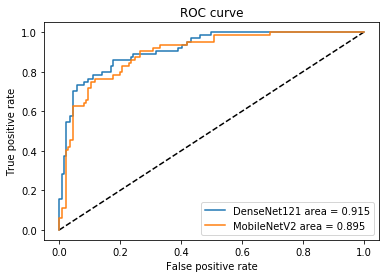

In [48]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_densenet, tpr_densenet, label='DenseNet121 area = {:.3f}'.format(auc_densenet))
plt.plot(fpr_mobilenet, tpr_mobilenet, label='MobileNetV2 area = {:.3f}'.format(auc_mobilenet))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Bootstrapped AUC for confidence intervals.

In [49]:
from sklearn.utils import resample
n_bootstraps = 10000
seed = 42
bootstrapped_mobilenet = []
bootstrapped_densenet = []

for i in range(n_bootstraps):
    # prepare bootstrap sample
    boot = resample(test, replace=True, n_samples=50)
    if len(np.unique(boot['label'])) == 2:
        score_mobilenet = roc_auc_score(boot['label'], boot['mobilenet'])
        bootstrapped_mobilenet.append(score_mobilenet)
        
        score_densenet = roc_auc_score(boot['label'], boot['densenet'])
        bootstrapped_densenet.append(score_densenet)

sorted_mobilenet = np.array(bootstrapped_mobilenet)
sorted_mobilenet.sort()

sorted_densenet = np.array(bootstrapped_densenet)
sorted_densenet.sort()

confidence_lower_densenet = sorted_densenet[int(0.025 * len(sorted_densenet))]
confidence_upper_densenet = sorted_densenet[int(0.975 * len(sorted_densenet))]
print("Confidence interval for DenseNet121: [{:0.3f} - {:0.3}]".format(
    confidence_lower_densenet, confidence_upper_densenet))

confidence_lower_mobilenet = sorted_mobilenet[int(0.025 * len(sorted_mobilenet))]
confidence_upper_mobilenet = sorted_mobilenet[int(0.975 * len(sorted_mobilenet))]
print("Confidence interval for MobileNetV2: [{:0.3f} - {:0.3}]".format(
    confidence_lower_mobilenet, confidence_upper_mobilenet))

Confidence interval for DenseNet121: [0.821 - 0.984]
Confidence interval for MobileNetV2: [0.789 - 0.975]


Get some other simple statistics for comparisons

Overall we see that we are not significantly different from current state of the art models for the task of predicting pleural effusions.

Lets see if certain groups by age and gender perform worst

In [69]:
##clean up the age to int then create buckets
test['Age'] = test['Age'].astype(str).astype(int)
age_buckets = [0, 2, 5, 13, 18, 33, 48, 64, 78, 98]
test['age_bucket'] = pd.cut(test['Age'], age_buckets)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
patient_id        200 non-null object
study_id          200 non-null object
Sex               200 non-null object
Age               200 non-null int64
label             200 non-null object
mobilenet         200 non-null float32
densenet          200 non-null float32
mobilenet_pred    200 non-null float32
densenet_pred     200 non-null float32
age_bucket        200 non-null category
dtypes: category(1), float32(4), int64(1), object(4)
memory usage: 11.4+ KB


In [70]:
#mapping to different labels
labelMap = {'0': 0, '1' : 1, '-1' : 1}
test['label'] = test['label'].map(labelMap)
test['missclass_densenet'] = (test['label'] - test['densenet_pred']).abs()
test['missclass_mobilenet'] = (test['label'] - test['mobilenet_pred']).abs()

In [71]:
propPleural = test.groupby(['age_bucket'])['missclass_densenet'].mean()
propPleural

age_bucket
(0, 2]           NaN
(2, 5]           NaN
(5, 13]          NaN
(13, 18]    0.000000
(18, 33]    0.000000
(33, 48]    0.166667
(48, 64]    0.086207
(64, 78]    0.156863
(78, 98]    0.200000
Name: missclass_densenet, dtype: float64

In [72]:
propPleural = test.groupby(['age_bucket'])['missclass_mobilenet'].mean()
propPleural

age_bucket
(0, 2]           NaN
(2, 5]           NaN
(5, 13]          NaN
(13, 18]    0.000000
(18, 33]    0.000000
(33, 48]    0.233333
(48, 64]    0.103448
(64, 78]    0.176471
(78, 98]    0.225000
Name: missclass_mobilenet, dtype: float64

### Appendix

In [14]:

def load_from_weights(conv_base, weights, shape = (320,320,3), pop = False):
    
    if conv_base == 'VGG16':
        from keras.applications.vgg16 import VGG16 as BASE
    elif conv_base == 'ResNet152':
        from keras_applications.resnet import ResNet152 as BASE
    elif conv_base == 'DenseNet121':
        from keras.applications.densenet import DenseNet121 as BASE
    elif conv_base == 'NASNetMobile':
        from keras.applications.nasnet import NASNetMobile as BASE
    elif conv_base == 'MobileNetV2':
        from keras.applications.mobilenet_v2 import MobileNetV2 as BASE
    elif conv_base == 'Xception':
        from keras.applications.xception import Xception as BASE
    else:
        raise ValueError('Unknown model: {}'.format(conv_base))
    
    if pop:
        conv_base = BASE(include_top=True, weights=None, pooling=max)

        conv_base.layers.pop()
        
        #set all the layers to trainable
        conv_base.trainable = True
        for layer in conv_base.layers:
            layer.trainable = True

        model = models.Sequential()
        model.add(conv_base)
        model.add(layers.Dense(1, activation='sigmoid'))

        model.load_weights(weights)

        model.compile(loss='binary_crossentropy', optimizer= optimizers.Adam(), metrics=['accuracy'])
        
    else:
        conv_base = BASE(include_top=False,
                         weights=None,
                         input_shape=shape,
                         pooling=max)

        #set all the layers to trainable
        conv_base.trainable = True
        for layer in conv_base.layers:
            layer.trainable = True

        model = models.Sequential()
        model.add(conv_base)
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(1, activation='sigmoid'))

        model.load_weights(weights)

        model.compile(loss='binary_crossentropy', optimizer= optimizers.Adam(), metrics=['accuracy'])
    return model